In [1]:
%reload_ext autoreload
%autoreload 2
from sklearn.calibration import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from scipy import stats
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# statistics
import scipy.stats as sc
# hierarchical clustering, clusters
from scipy.cluster.hierarchy import linkage, cut_tree, leaves_list
from scipy import stats
from common import load_data, pareto_rank, baseline_results

In [16]:
# Read data from disk
(
    perf_matrix_initial,
    input_features,
    config_features,
    all_performances,
    input_preprocessor,
    config_preprocessor,
) = load_data(system="x264", data_dir="../data", input_properties_type="tabular")

In [17]:
# Data Loading
random_state = 1234
test_size = 0.40
pareto_cutoff = 0.75
rank_by_domination_count = False

# performances = ["fps", "cpu"]
# performances = ["kbs", "fps"]
performances = []

if len(performances) == 0:
    performances = all_performances

# Normalization is needed for the Pareto cutoff
# We can normalize before splitting, because
# we normalize per input and we also split per input.
# There is no data leakage.
normalized_metrics = (
    perf_matrix_initial[["inputname"] + performances]
    .groupby("inputname", as_index=False)
    .transform(lambda x: (x - x.min()) / (x.max() - x.min()))
)
cutoff_mask = (normalized_metrics <= pareto_cutoff).all(axis=1)

nmdf = (
    perf_matrix_initial[["inputname"] + performances]
    .groupby("inputname", as_index=True)
    .transform(lambda x: (x - x.min()) / (x.max() - x.min()))
)
perf_matrix = pd.merge(
    perf_matrix_initial, nmdf, suffixes=("_raw", None), left_index=True, right_index=True
)
perf_matrix["feasible"] = cutoff_mask

all_perf_raw = [f"{p}_raw" for p in performances]
all_perf_norm = [f"{p}" for p in performances]

icm_all = (
    perf_matrix[["inputname", "configurationID"] + performances]
    .sort_values(["inputname", "configurationID"])
    .set_index(["inputname", "configurationID"])
)
icm_ranked_measures = icm_all.groupby(
    "inputname"
).transform(  # Go from measured values to ranks within each input group
    lambda x: stats.rankdata(x, method="min")
)
icm_all["ranks"] = icm_all.groupby("inputname", group_keys=False).apply(
    lambda x: pareto_rank(
        x, cutoff=pareto_cutoff, rank_by_domination_count=rank_by_domination_count
    )
)

In [13]:
from common import pareto_rank_numpy
v = icm_all.loc[("Animation_1080P-01b3",)][performances].values
pareto_rank_numpy(v)

array([2, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 2, 2, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1,
       1, 1, 1], dtype=int32)

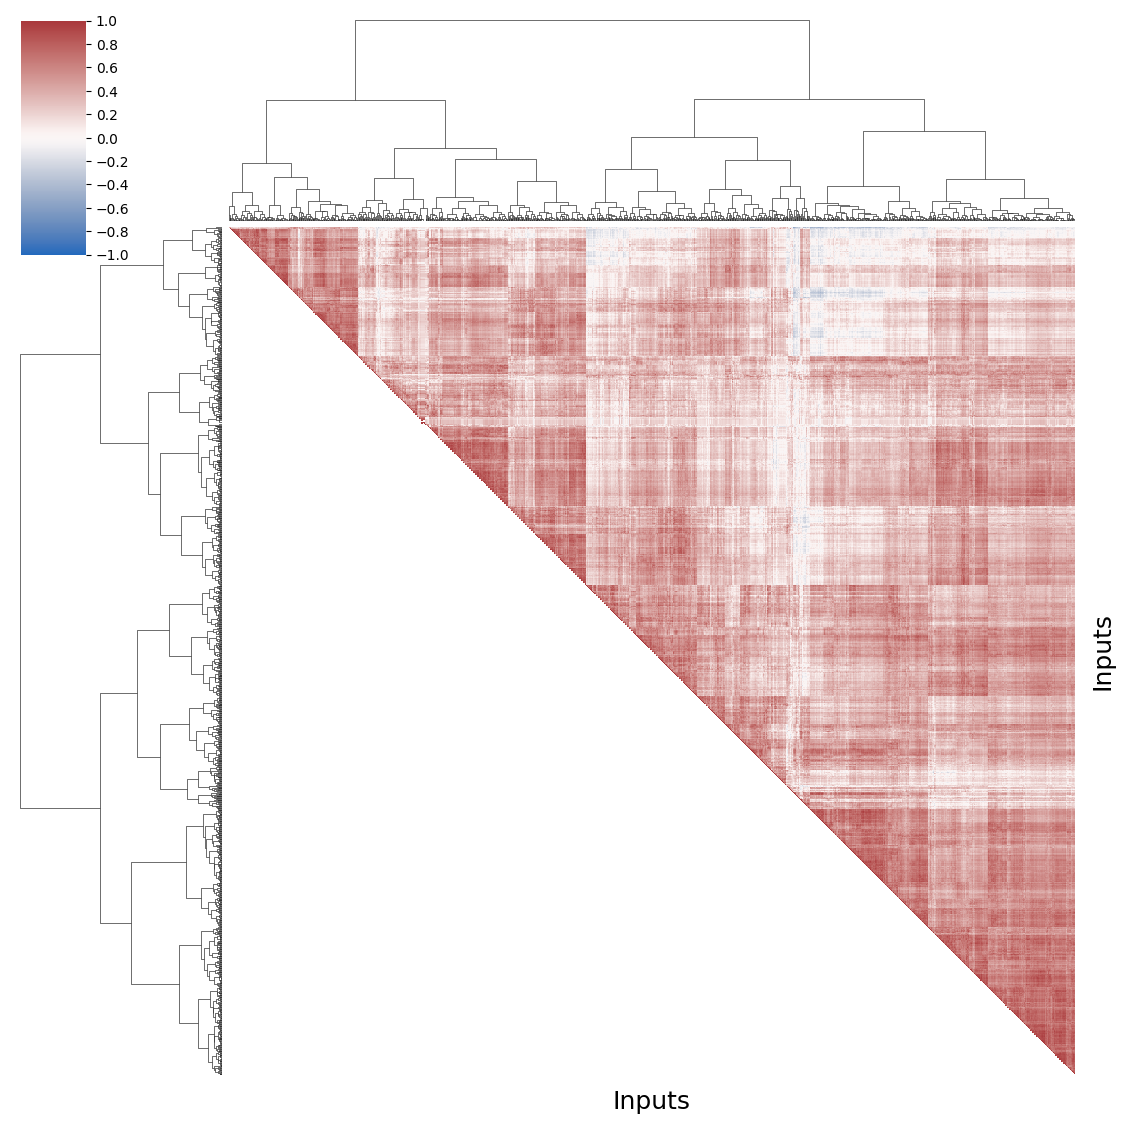

count    827541.00
mean          0.36
std           0.20
min          -0.58
25%           0.22
50%           0.35
75%           0.50
max           1.00
dtype: float64

In [19]:
def get_cluster_data(performances=[]):
    if len(performances) == 0:
        performances = all_performances

    # Normalization is needed for the Pareto cutoff
    # We can normalize before splitting, because
    # we normalize per input and we also split per input.
    # There is no data leakage.
    normalized_metrics = (
        perf_matrix_initial[["inputname"] + performances]
        .groupby("inputname", as_index=False)
        .transform(lambda x: (x - x.min()) / (x.max() - x.min()))
    )
    cutoff_mask = (normalized_metrics <= pareto_cutoff).all(axis=1)

    nmdf = (
        perf_matrix_initial[["inputname"] + performances]
        .groupby("inputname", as_index=True)
        .transform(lambda x: (x - x.min()) / (x.max() - x.min()))
    )
    perf_matrix = pd.merge(
        perf_matrix_initial, nmdf, suffixes=("_raw", None), left_index=True, right_index=True
    )
    perf_matrix["feasible"] = cutoff_mask

    icm_all = (
        perf_matrix[["inputname", "configurationID"] + performances]
        .sort_values(["inputname", "configurationID"])
        .set_index(["inputname", "configurationID"])
    )
    icm_all["ranks"] = icm_all.groupby("inputname", group_keys=False).apply(
        lambda x: pareto_rank(
            x, cutoff=pareto_cutoff, rank_by_domination_count=rank_by_domination_count
        )
    )

    # Needed: (inp, rank over configs)
    clustericm = icm_all.reset_index().sort_values(["inputname", "configurationID"])
    return clustericm


def plot_correlationmatrix_dendogram(data, dim):
    # ns : name_system
    # dim : dimension
    # output : a plot of an ordered correlogram of the different compile-time options
    
    # number of inputs
    inputs_nb = data.inputname.nunique()

    inp_cfg_matrix = data[["inputname", "configurationID", dim]].pivot(index="inputname", columns='configurationID', values=dim)
    # inp_cfg_matrix = inp_cfg_matrix.replace(202, np.nan)
    # Calculate correlation 
    df = inp_cfg_matrix.T.corr(method="spearman")
    corr = df.values

    # we replace nan correlations (with a distribution whose values are all equal to 0)
    df = df.fillna(0)

    # group the videos, we choose the ward method 
    # single link method (minimum of distance) leads to numerous tiny clusters
    # centroid or average tend to split homogeneous clusters
    # and complete link aggregates unbalanced groups. 
    links = linkage(df, method="ward",)
    order = leaves_list(links)
    
    # Generate a mask for the upper triangle
    # we order the correlation following the aggregation clustering
    mask = np.zeros_like(corr, dtype=bool)

    for i in range(inputs_nb):
        for j in range(inputs_nb):    
            if i>j:
                mask[order[i]][order[j]] = True
    
    # compute the actual clustermap
    g = sns.clustermap(df, cmap="vlag", mask=mask, method="ward",
                   linewidths=0, figsize=(13, 13), 
                   cbar_kws={"ticks":[k/5 for k in np.arange(-10,10,1)]}, 
                   vmin =-1)
    g.ax_heatmap.set_yticklabels([])
    g.ax_heatmap.set_xticklabels([])
    g.ax_heatmap.tick_params(right=False, bottom=False)
    # abcissa and ordered labels
    g.ax_heatmap.set_xlabel("Inputs", fontsize = 18)
    g.ax_heatmap.set_ylabel("Inputs", fontsize = 18)
    # we save the figure in the result folder
    # plt.savefig("../../../results/systems/"+ns+"/"+"corr_"+dim+".png")
    # we show the graph
    plt.show()
    
    return corr

def describe(corr):
    corrDescription = [corr[i][j] for i in range(len(corr)) 
                              for j in range(len(corr)) if i >j]
    
    return np.round(pd.Series(corrDescription).describe(), 2)

corr = plot_correlationmatrix_dendogram(get_cluster_data([]), "ranks")
describe(corr)

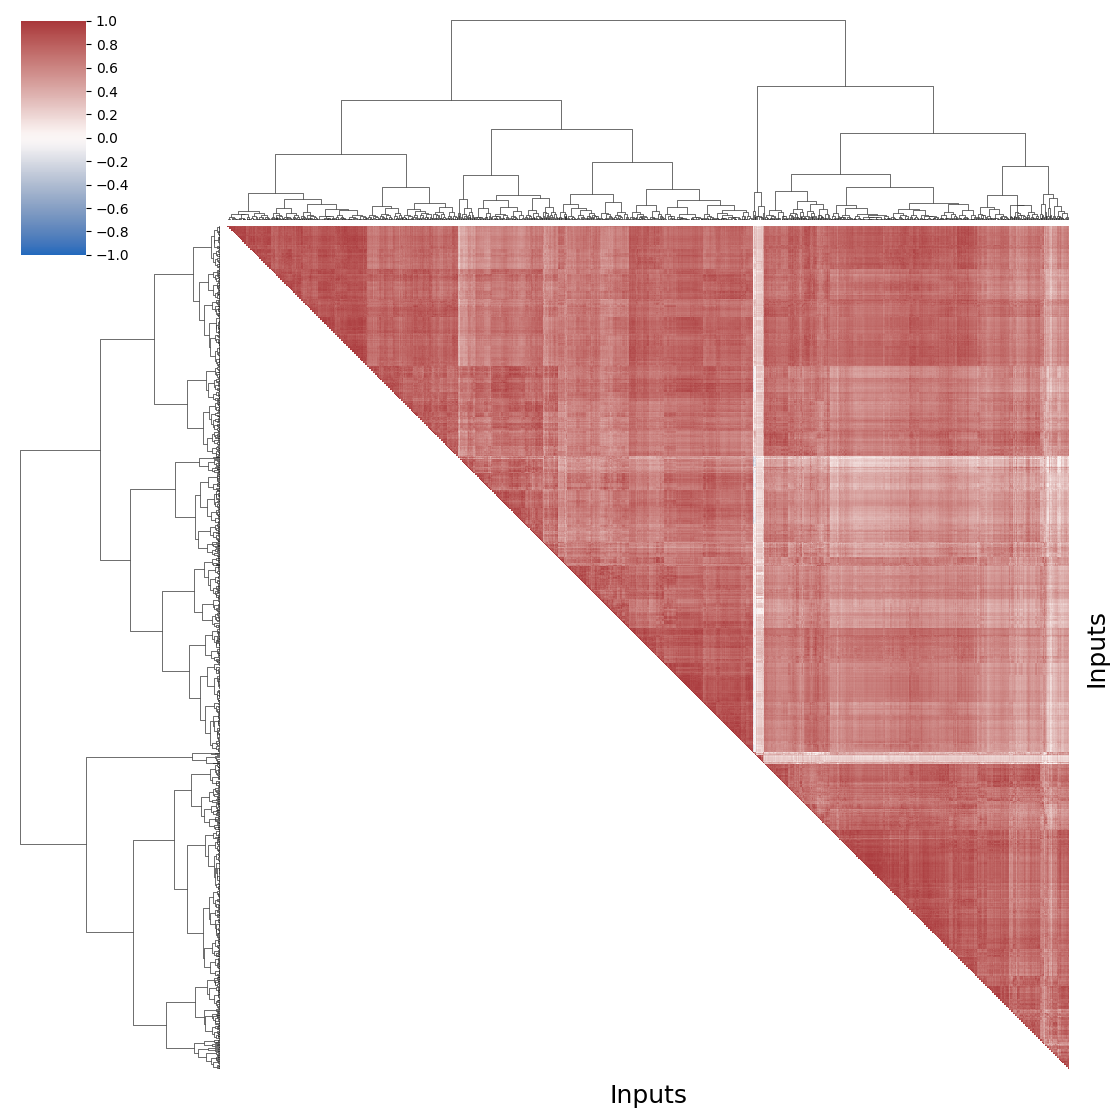

count    827541.00
mean          0.65
std           0.15
min          -0.41
25%           0.57
50%           0.67
75%           0.76
max           1.00
dtype: float64

In [20]:
corr = plot_correlationmatrix_dendogram(get_cluster_data(["fps", "kbs"]), "ranks")
describe(corr)

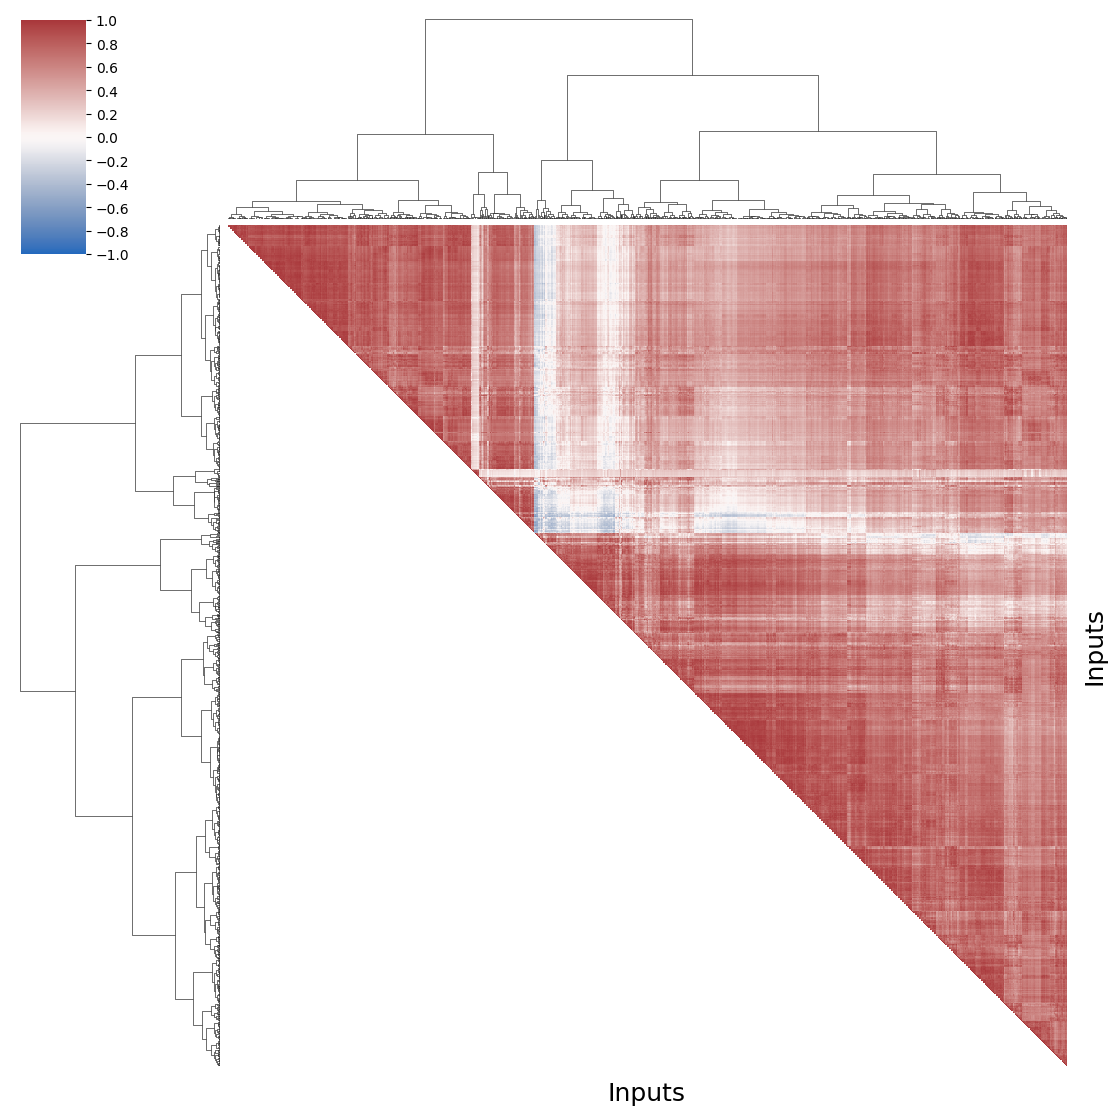

count    827541.00
mean          0.55
std           0.25
min          -0.67
25%           0.42
50%           0.60
75%           0.74
max           1.00
dtype: float64

In [21]:
corr = plot_correlationmatrix_dendogram(get_cluster_data(["kbs"]), "ranks")
describe(corr)